In [1]:
import torchvision
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Bottleneck(nn.Module):
    expansion = 2
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False, groups=32)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        
        return out

In [3]:
class ResNeXt(nn.Module):
    
    def __init__(self, block, layers, num_classes=1000):
    #def __init__(self):
        self.inplanes = 64
        super(ResNeXt, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 128, layers[0])
        self.layer2 = self._make_layer(block, 256, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[2], stride=2)                
        self.layer4 = self._make_layer(block, 1024, layers[3], stride=2)       

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)        
        return x

In [4]:
model = ResNeXt(Bottleneck, [2, 2, 2, 2], num_classes=10)

In [5]:
test_inputs = torch.randn((16,3,224,224))

In [6]:
x = model(test_inputs)
print(x.shape)


torch.Size([16, 2048, 7, 7])


cardinalities ``C``, width of the bottleneck ``d``

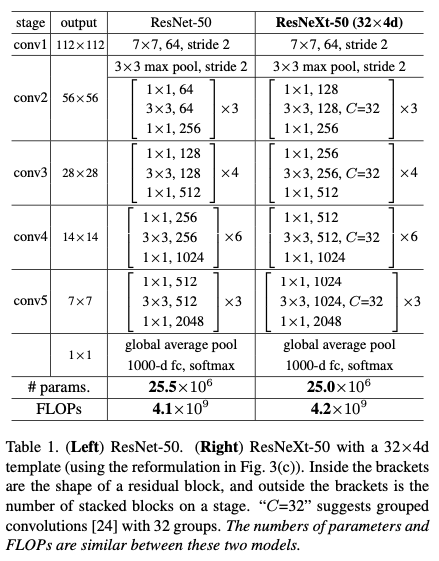

In [7]:
for name, params in model.state_dict().items():
    print('name:{}, shape:{}'.format(name,params.data.size()))

name:conv1.weight, shape:torch.Size([64, 3, 7, 7])
name:bn1.weight, shape:torch.Size([64])
name:bn1.bias, shape:torch.Size([64])
name:bn1.running_mean, shape:torch.Size([64])
name:bn1.running_var, shape:torch.Size([64])
name:bn1.num_batches_tracked, shape:torch.Size([])
name:layer1.0.conv1.weight, shape:torch.Size([128, 64, 1, 1])
name:layer1.0.bn1.weight, shape:torch.Size([128])
name:layer1.0.bn1.bias, shape:torch.Size([128])
name:layer1.0.bn1.running_mean, shape:torch.Size([128])
name:layer1.0.bn1.running_var, shape:torch.Size([128])
name:layer1.0.bn1.num_batches_tracked, shape:torch.Size([])
name:layer1.0.conv2.weight, shape:torch.Size([128, 4, 3, 3])
name:layer1.0.bn2.weight, shape:torch.Size([128])
name:layer1.0.bn2.bias, shape:torch.Size([128])
name:layer1.0.bn2.running_mean, shape:torch.Size([128])
name:layer1.0.bn2.running_var, shape:torch.Size([128])
name:layer1.0.bn2.num_batches_tracked, shape:torch.Size([])
name:layer1.0.conv3.weight, shape:torch.Size([256, 128, 1, 1])
name: